# Dev for tapers to merge velocity models

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

from obspy import Trace

Populating the interactive namespace from numpy and matplotlib


In [2]:
def calc_taper(npts, taper_width, type='hann', side='both'):
    """
    Calculate a taper
    
    Parameters
    ----------
    npts: int
        Length of the taper array
    taper_width: int
        Width of taper in points
    
    ... note:: Uses `obspy.Trace.taper`, for now
    """
    
    assert taper_width < npts/2., 'taper_width must be less than npts/2'
    
    max_percentage = taper_width / npts
    
    
    
    tr = Trace()
    
    tr.data = np.ones(npts)
    
    tr = tr.taper(max_percentage, type=type, side=side)
    
    
    return tr.data

## Calculating a single taper

/usr/local/lib/python3.6/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


Text(0,0.5,'Taper value')

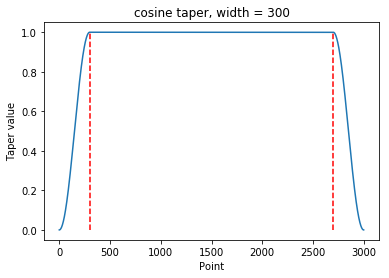

In [3]:
npts = 3000
taper_width = 300
type = 'cosine'

taper = calc_taper(npts, taper_width, type=type)


plt.plot(taper)
plt.plot([taper_width, taper_width], [0, 1], '--r')
plt.plot([npts - taper_width, npts - taper_width], [0, 1], '--r')

plt.title('{:} taper, width = {:}'.format(type, taper_width))

plt.xlabel('Point')
plt.ylabel('Taper value')

## Taper for 50/50 blend of two values

/usr/local/lib/python3.6/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


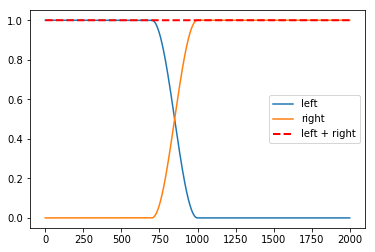

In [4]:
npts = 1000
taper_width = 300
type = 'cosine'


left = calc_taper(npts, taper_width, type=type, side='right')
left = np.concatenate([left, np.zeros(npts)])
right = 1. - left

plt.plot(left, label='left')
plt.plot(right, label='right')

plt.plot(left + right, '--r', lw=2, label='left + right')

plt.legend()

## How to handle case where one side is significantly different than the other?

#### Example

Normal taper results in step-wise change over merge

/usr/local/lib/python3.6/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


Text(0.5,1,'Merged data')

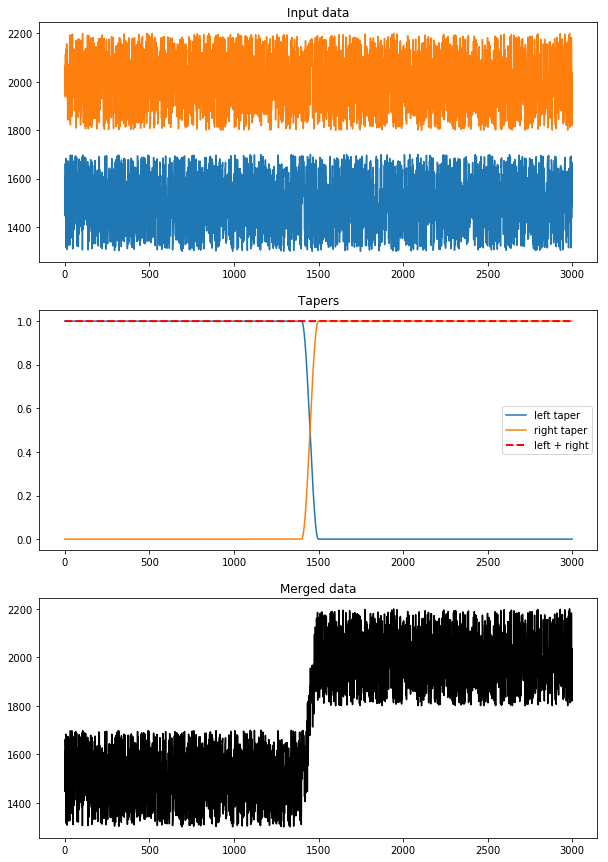

In [5]:
npts = 3000
ijoin = 1500 # where to merge
taper_width = 100

# example data
ldat = 1500 + 200 * 2 * (np.random.rand(npts) - 0.5)
rdat = 2000 + 200 * 2 * (np.random.rand(npts) - 0.5)

# calc tapers
ltaper = calc_taper(ijoin, taper_width, type=type, side='right')
ltaper = np.concatenate([ltaper, np.zeros(npts - ijoin)])
rtaper = 1. - ltaper


merge = ldat * ltaper + rdat * rtaper


# plot
fig = plt.figure(figsize(10, 15))
ax = fig.add_subplot(311)
ax.plot(ldat, label='left')
ax.plot(rdat, label='right')

ax.set_title('Input data')

ax = fig.add_subplot(312)
ax.plot(ltaper, label='left taper')
ax.plot(rtaper, label='right taper')
ax.plot(ltaper + rtaper, '--r', lw=2, label='left + right')

ax.legend()

ax.set_title('Tapers')


ax = fig.add_subplot(313)
ax.plot(merge, '-k')

ax.set_title('Merged data')

### Idea: Taper long-wavelength structure separately from short-wavelengths

/usr/local/lib/python3.6/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


(2000, 6000)

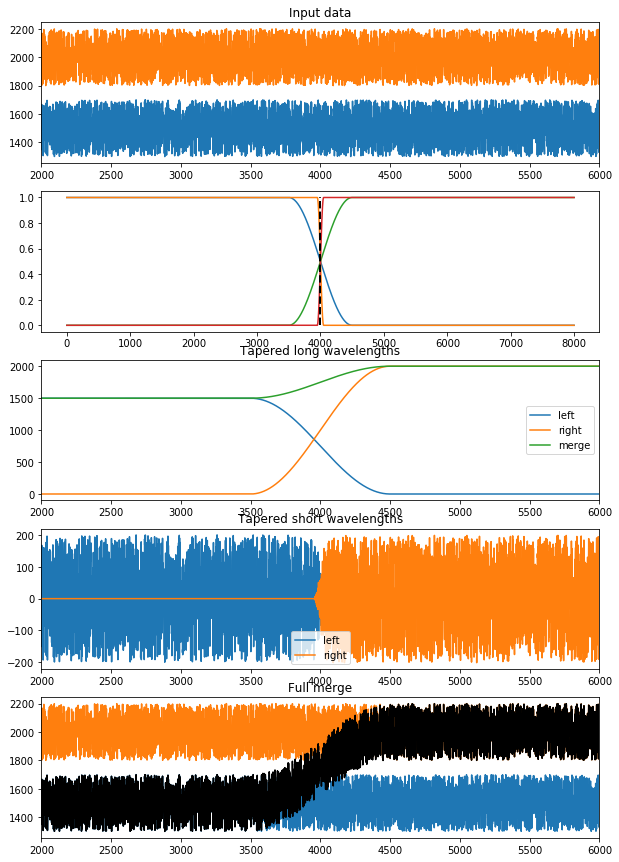

In [8]:
type = 'cosine'
npts = 8000
ijoin = 4000 # where to merge
long_taper_width = 1000
short_taper_width = 100

# example data
ldat = 1500 + 200 * 2 * (np.random.rand(npts) - 0.5)
rdat = 2000 + 200 * 2 * (np.random.rand(npts) - 0.5)


# taper long wavelengths
ltaper0 = calc_taper(int(ijoin + long_taper_width/2), long_taper_width, type=type, side='right')
ltaper0 = np.concatenate([ltaper0, np.zeros(npts - len(ltaper0))])
rtaper0 = 1. - ltaper0

left0 = np.mean(ldat)
right0 = np.mean(rdat)

left0_tapered = left0 * ltaper0
right0_tapered = right0 * rtaper0

merge0 = left0_tapered + right0_tapered

# taper short wavelengths
left1 = ldat - left0
right1 = rdat - right0

ltaper1 = calc_taper(int(ijoin + short_taper_width/2), short_taper_width, type=type, side='right')
ltaper1 = np.concatenate([ltaper1, np.zeros(npts - len(ltaper1))])
rtaper1 = 1. - ltaper1

left1_tapered = left1 * ltaper1
right1_tapered = right1 * rtaper1

merge1 = left1_tapered + right1_tapered


merge = merge0 + merge1

# plot
xlim = (2000, 6000)
fig = plt.figure(figsize(10, 15))
ax = fig.add_subplot(511)
ax.plot(ldat, label='left')
ax.plot(rdat, label='right')

ax.set_title('Input data')
ax.set_xlim(xlim)

ax = fig.add_subplot(512)
ax.plot(ltaper0, label='left (long)')
ax.plot(ltaper1, label='left (short)')
ax.plot(rtaper0, label='right (long)')
ax.plot(rtaper1, label='right (short)')
ax.plot([ijoin, ijoin], [0, 1], '--k', lw=2)


ax = fig.add_subplot(513)
ax.plot(left0_tapered, label='left')
ax.plot(right0_tapered, label='right')
ax.plot(merge0, label='merge')
ax.legend()
ax.set_title('Tapered long wavelengths')
ax.set_xlim(xlim)



ax = fig.add_subplot(514)
ax.plot(left1_tapered, label='left')
ax.plot(right1_tapered, label='right')
#ax.plot(merge1, label='merge')
ax.legend()
ax.set_title('Tapered short wavelengths')
ax.set_xlim(xlim)



ax = fig.add_subplot(515)
ax.plot(ldat, label='left')
ax.plot(rdat, label='right')
ax.plot(merge, '-k')

ax.set_title('Full merge')
ax.set_xlim(xlim)



### Can we weight one side over with the double taper?

/usr/local/lib/python3.6/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


(2000, 6000)

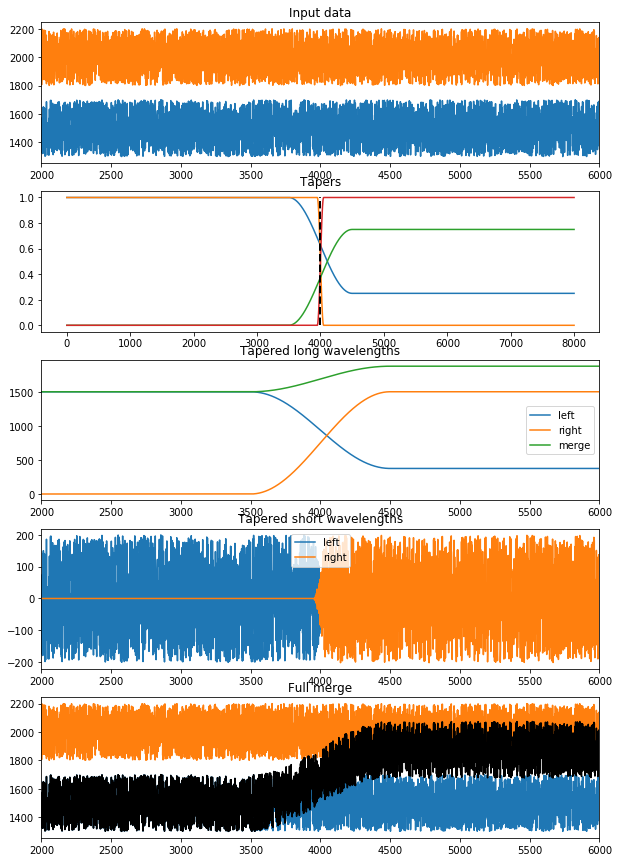

In [54]:
type = 'cosine'
npts = 8000
ijoin = 4000 # where to merge
long_taper_width = 1000
short_taper_width = 100

#weights
left_fac_long = 0.75
left_fac_short = 1.

assert (left_fac_long <= 1) and (left_fac_long >= 0), 'left_fac_long must be >=0 and <=1'
assert (left_fac_short <= 1) and (left_fac_short >= 0), 'left_fac_short must be >=0 and <=1'



# example data
ldat = 1500 + 200 * 2 * (np.random.rand(npts) - 0.5)
rdat = 2000 + 200 * 2 * (np.random.rand(npts) - 0.5)


# taper long wavelengths
ltaper0 = calc_taper(int(ijoin + long_taper_width/2), long_taper_width, type=type, side='right')
ltaper0 = np.concatenate([ltaper0, np.zeros(npts - len(ltaper0))])

ltaper0 = ltaper0 * left_fac_long + (1 - left_fac_long)


rtaper0 = 1. - ltaper0

left0 = np.mean(ldat) * np.ones(len(ldat))
right0 = np.mean(rdat) * np.ones(len(rdat))

left0_tapered = left0 * ltaper0
right0_tapered = right0 * rtaper0

merge0 = left0_tapered + right0_tapered


# taper short wavelengths
left1 = ldat - left0
right1 = rdat - right0

ltaper1 = calc_taper(int(ijoin + short_taper_width/2), short_taper_width, type=type, side='right')
ltaper1 = np.concatenate([ltaper1, np.zeros(npts - len(ltaper1))])

ltaper1 = ltaper1 * left_fac_short + (1. - left_fac_short)


rtaper1 = 1. - ltaper1

left1_tapered = left1 * ltaper1
right1_tapered = right1 * rtaper1

merge1 = left1_tapered + right1_tapered


merge = merge0 + merge1


# plot
xlim = (2000, 6000)
fig = plt.figure(figsize(10, 15))
ax = fig.add_subplot(511)
ax.plot(ldat, label='left')
ax.plot(rdat, label='right')

ax.set_title('Input data')
ax.set_xlim(xlim)

ax = fig.add_subplot(512)
ax.plot(ltaper0, label='left (long)')
ax.plot(ltaper1, label='left (short)')
ax.plot(rtaper0, label='right (long)')
ax.plot(rtaper1, label='right (short)')
ax.plot([ijoin, ijoin], [0, 1], '--k', lw=2)
ax.set_title('Tapers')



ax = fig.add_subplot(513)
ax.plot(left0_tapered, label='left')
ax.plot(right0_tapered, label='right')
ax.plot(merge0, label='merge')
ax.legend()
ax.set_title('Tapered long wavelengths')
ax.set_xlim(xlim)



ax = fig.add_subplot(514)
ax.plot(left1_tapered, label='left')
ax.plot(right1_tapered, label='right')
#ax.plot(merge1, label='merge')
ax.legend()
ax.set_title('Tapered short wavelengths')
ax.set_xlim(xlim)



ax = fig.add_subplot(515)
ax.plot(ldat, label='left')
ax.plot(rdat, label='right')
ax.plot(merge, '-k')

ax.set_title('Full merge')
ax.set_xlim(xlim)